# Single neuron optimization contest
____

**We are pleased to invite you to take part in an exciting challenge: do better than us in optimizing the [Layer 5 cortical interneuron](http://celltypes.brain-map.org/mouse/experiment/electrophysiology/475049291?mode-toggle.x=50&mode-toggle.y=55).**

** In order to do that, you will modify:**
1. The features you want to optimize for.
2. The parameters of the model.


These are the rules and guidelines:
1. You can change the features you want to optimize for, we will provide a list of the allowed ones.
2. You are allowed to change the model parameters. You can use the number of fixed parameters that you want, but you should have at least four free parameters.
3. You should not copy from the "orig_parameters.json" file.
4. We suggest to run an optimisation for 8 generations, with 10 individuals (it takes about 10-11 minutes).
5. You are encouraged to report any problems in the [chat channel](https://gitter.im/BlueBrain/SimulationTutorials) dedicated to this tutorial and also to discuss possible ways to solve the problem.   
6. Copy and paste the output of the last two cells of this notebook in a private chat with one of us ([Werner](https://gitter.im/wvangeit), [Christian](https://gitter.im/croessert), [Elisabetta](https://gitter.im/elisabettai)). Send us also your name/nickname. 
7. Hint: we will score your model based on how much it generalizes.
8. **Have fun** and possibly win some amazing prizes.

In [1]:
# Run this cell 

%load_ext autoreload
%autoreload

!nrnivmodl modfiles

from allensdk.api.queries.biophysical_api import BiophysicalApi
%matplotlib notebook
import matplotlib.pyplot as plt
import collections

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import numpy
import json

# Load the .nwb file containing the voltage traces
from allensdk.core.nwb_data_set import NwbDataSet
nwb_data = NwbDataSet('../ABI_model/data/475049288.nwb')

# Store data in a dictionary step_name:sweep_num
steps_dict = collections.OrderedDict(sorted({'StepNeg':23,'StepPos':36}.items(), key = lambda x:x[0]))

def get_data(dataset,sweeps_dict):
    # Correct for the liquid junction potential
    junction_potential = -14
    data = collections.OrderedDict()
    for step, sweep in sweeps_dict.items():
        sweep_data = {}
        # Get sweep from NWB dataset
        sweep = dataset.get_sweep(sweep)

        # Get stimulus from the sweep
        # stimulus = sweep['stimulus']

        # Sampling rate is in Hz
        sampling_rate = sweep['sampling_rate']
        
        # Start/stop indices that exclude the experimental test pulse (if applicable)
        index_range = sweep['index_range']
        
        # Response is a numpy array in mV
        sweep_data['V'] = sweep['response'][index_range[0]:index_range[1]]*1000+junction_potential    
        
        # Define some time points in milliseconds (i.e., convert to absolute time)
        sweep_data['T'] = numpy.arange(0,(len(sweep_data['V'])/sampling_rate),1./sampling_rate)*1000
        data[step] = sweep_data
    return data

data_dict = get_data(nwb_data, steps_dict)

/Users/iavarone/BBP/SimulationTutorials/FENS2016/exercise
modfiles/CaDynamics.mod modfiles/Ca_HVA.mod modfiles/Ca_LVA.mod modfiles/Ih.mod modfiles/Im.mod modfiles/Im_v2.mod modfiles/K_P.mod modfiles/K_T.mod modfiles/Kd.mod modfiles/Kv2like.mod modfiles/Kv3_1.mod modfiles/NaTa.mod modfiles/NaTs.mod modfiles/NaV.mod modfiles/Nap.mod modfiles/SK.mod
CaDynamics.mod Ca_HVA.mod Ca_LVA.mod Ih.mod Im.mod Im_v2.mod K_P.mod K_T.mod Kd.mod Kv2like.mod Kv3_1.mod NaTa.mod NaTs.mod NaV.mod Nap.mod SK.mod
"/Applications/NEURON-7.4/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/Applications/NEURON-7.4/nrn/include/nrn" -I"/Applications/NEURON-7.4/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/Applications/NEURON-7.4/nrn/include/nrn -I/Applications/NEURON-7.4/nrn/x86_64/lib -g -O2 -c mod_func.c  -fno-common -DPIC -o .libs/mod_func.o
"/Applications/NEURON-7.4/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -mod

## 1. Define the features (modify code)

Here is list of features you can choose:

'AHP1_depth_from_peak', 'AHP_depth', 'AHP_depth_from_peak', 'AHP_slow_time', 'AHP_time_from_peak', 'AP1_amp', 'AP1_begin_voltage', 'AP1_begin_width', 'AP1_peak', 'AP1_width', 'AP2_AP1_diff', 'AP2_AP1_peak_diff', 'AP2_amp', 'AP2_begin_voltage', 'AP2_begin_width', 'AP2_peak', 'AP2_width', 'AP_amplitude', 'AP_amplitude_change', 'AP_amplitude_diff', 'AP_amplitude_from_voltagebase', 'AP_begin_voltage', 'AP_begin_width', 'AP_duration', Spikecount', 'adaptation_index', 'adaptation_index2', 'fast_AHP', 'min_AHP_values', 'min_voltage_between_spikes', 'minimum_voltage', 'peak_voltage','time_constant', 'time_to_first_spike','voltage_base', 'voltage_deflection', 'voltage_deflection_begin'].

You can find a documentation for each of them [here](http://bluebrain.github.io/eFEL/eFeatures.html#implemented-efeatures-to-be-continued). Once you have chosen your features, insert them in the code below. The list "pas_feature_names" containes the features you chose for the negative current step, while the "act_feature_names" is for the positive current step.

After executing the following cell check the output to see if the features names are correct.

In [2]:
# Insert here the list of features you want to extract from the negative stimulus
pas_feature_names = ['time_constant','voltage_deflection_begin']

# Insert here the list of features you want to extract from the negative stimulus
act_feature_names = ['mean_frequency', 'AP_amplitude', 'fast_AHP','min_AHP_values', 'AP_duration']

################################################################################

import efel

def get_features(data):
    
    traces_pas = []
    traces_act = []
    for step_name, step_traces in data.items():
        trace = {}
        trace['T'] = data[step_name]['T']
        trace['V'] = data[step_name]['V']
        trace['stim_start'] = [270]
        trace['stim_end'] = [1270]
        trace['name'] = step_name
    
        if 'Pos' in step_name:
            traces_act.append(trace)       
        else:
            traces_pas.append(trace)

    features_values = efel.getMeanFeatureValues(traces_pas, pas_feature_names)
    features_values_act = efel.getMeanFeatureValues(traces_act, act_feature_names) 
    features_values.extend(features_values_act)
    return features_values

efel_features = get_features(data_dict)

# Write features mean values and std in a json file
features_dict = collections.OrderedDict()
for step_name, features in zip(steps_dict.iterkeys(), efel_features):
    features_dict[step_name] = {"soma":{}}
    for name, value in features.items():
        features_dict[step_name]["soma"][name] = [value, abs(value*0.05)]    
    
with open('./config/features.json', 'w') as fp:
    json.dump(features_dict, fp, indent = 4)
    
my_features = json.load(open('./config/features.json'))
for step in my_features:
    if step == 'StepNeg':
        print "The features for the negative step are: " + str(my_features[step]['soma'].keys())
    else:
        print "The features for the positive step are: " + str(my_features[step]['soma'].keys())

The features for the negative step are: [u'time_constant', u'voltage_deflection_begin']
The features for the positive step are: [u'AP_duration', u'mean_frequency', u'AP_amplitude', u'fast_AHP', u'min_AHP_values']


# 2. Parameters (modify code)

The parameters that you can modify are the ion channel maximal conductances. For each parameter you want to modify you need to specify:

1. The location "somatic", "basal" (*i.e.* dendrites) or "axonal".
2. The name of the channels (with the prefix 'gbar').
3. The value for the conductances. It can be either a fixed value or a range [min, max], in the latter case it means that you want to optimize that value.

Not all combinations of 1) and 2) are possible, but you should follow the initial distribution of the channels, that is:
* somatic: 'g_pas', 'gbar_NaV', 'gbar_SK', 'gbar_Kv3_1', 'gbar_Ca_HVA', 'gbar_Ca_LVA', 'gbar_Ih'.
* axonal: 'g_pas', 'gbar_NaV', 'gbar_K_T', 'gbar_Kd', 'gbar_Kv2like', 'gbar_Kv3_1', 'gbar_SK', 'gbar_Ca_HVA', 'gbar_Ca_LVA'.
* basal: 'g_pas', 'gbar_NaV', 'gbar_Kv3_1', 'gbar_Im_v2', 'gbar_Ih'.

If don't have any idea on how to choose the range for your free parameters, you can have look to the ["Biophysical Modeling - All-active white paper"](http://help.brain-map.org/download/attachments/8323525/BiophysModelAllActive.pdf?version=1&modificationDate=1456524876599), pag. 5, Table 2.

In the code below there is an example on how to modify the conductance of the channel 'NaV' in the axonal sections, to a range value [1e-7, 0.1]. There is also a line for changing the 'Ih' conductance in the basal sections to a fixed value (7e-4). You can modify these two lines and add more, but pay attention to the sintax!


In [3]:
# Write here your parameters dictionary, following the syntax in the example.
# You should not modify the keys 'new_section', 'new_mech_name', 'new_value'.

my_pars = [
{'new_section':'axonal', 'new_mech_name': 'gbar_NaV', 'new_value':[1e-7, 0.1]},
{'new_section':'basal', 'new_mech_name': 'gbar_Ih', 'new_value': [7e-5]},
{'new_section':'axonal', 'new_mech_name': 'gbar_Kv2like', 'new_value': [7e-5, 0.01]},
{'new_section':'basal', 'new_mech_name': 'gbar_Im_v2', 'new_value': [0.01]}

]

############################################################################

start_pars = json.load(open('config/parameters_start.json'))

for my_dict in my_pars:
    for old_dict in start_pars:
        if old_dict['type'] != 'global':
            if my_dict['new_section'] == old_dict['sectionlist'] and old_dict['param_name'] == my_dict['new_mech_name']:
                old_dict['param_name'] = my_dict['new_mech_name']
                if len(my_dict['new_value']) > 1:
                    old_dict['bounds'] = my_dict['new_value']
                    if 'value' in old_dict:
                        old_dict.pop('value')
                else:
                    old_dict['value'] = my_dict['new_value'][0]
                    if 'bounds' in start_pars:
                        old_dict.pop('bounds')
                    
with open('./config/parameters.json', 'w') as fp:
    json.dump(start_pars, fp, indent = 4)            

Run the following cell to check if your parameters have been correctly set.

In [4]:
import cell_model

morphology_file = 'Sst-IRES-Cre_Ai14_IVSCC_-183332.05.02.01_486041253_m.swc'
parameters = cell_model.define_parameters()
morphology = ephys.morphologies.NrnFileMorphology(morphology_file, do_replace_axon=True)
mechanisms = cell_model.define_mechanisms()
abi_cell = ephys.models.CellModel('abi_cell', morph=morphology, mechs=mechanisms, params=parameters)

param_names = [param.name for param in abi_cell.params.values() if not param.frozen]
new_pars = json.load(open('config/parameters.json'))

fixed_pars = []
for my_dict in my_pars:
    for old_dict in new_pars:
        if old_dict['type'] != 'global':
            if my_dict['new_section'] == old_dict['sectionlist'] and old_dict['param_name'] == my_dict['new_mech_name'] and len(my_dict['new_value']) == 1:
                fixed_pars.append((my_dict['new_mech_name'], my_dict['new_value']))
                
print "My fixed parameters are: " + str(fixed_pars) 
print "My free parameters are: " + str(param_names)

My fixed parameters are: [('gbar_Ih', [7e-05]), ('gbar_Im_v2', [0.01])]
My free parameters are: [u'gbar_NaV.axonal', u'gbar_Kv2like.axonal']


Set-up and run the optimisation. 

In [5]:
num_gen = 8

import cell_evaluator
import pickle

proto_configs = json.load(open('config/protocols.json'))
fitness_protocols = cell_evaluator.define_protocols()

# Set-up a simulation and a fitness calculator
sim = ephys.simulators.NrnSimulator()
fitness_calculator = cell_evaluator.define_fitness_calculator(fitness_protocols)

evaluator = ephys.evaluators.CellEvaluator(                                          
        cell_model=abi_cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)  

# Run for 8 generations
import time

opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=10) 

start = time.time()
results = opt.run(max_ngen=num_gen, cp_filename='checkpoints/checkpoint_'+str(num_gen)+'.pkl')
end = time.time()
print "\nRun time in seconds: " + str(end-start)


Run time in seconds: 350.197782993


<IPython.core.display.Javascript object>


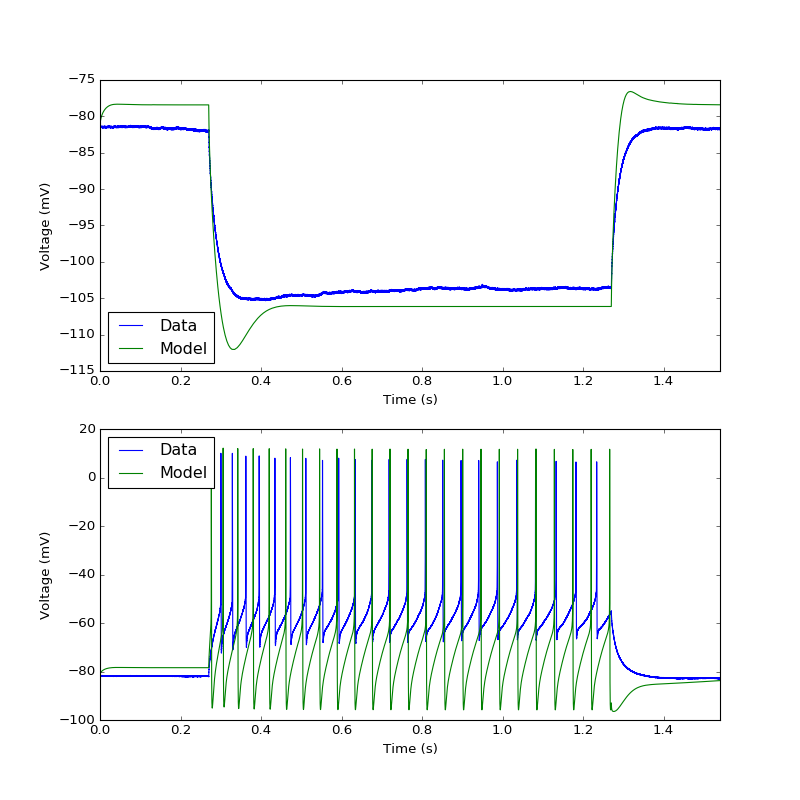

gen	nevals	avg    	std    	min    	max    
1  	10    	285.539	157.735	43.9317	389.064
2  	10    	285.497	157.829	43.7749	389.064
3  	10    	148.982	156.85 	43.7119	388.683
4  	10    	148.451	157.142	43.7119	388.709
5  	10    	149.58 	156.403	43.8462	388.45 
6  	10    	65.7706	74.3142	43.8462	388.225
7  	10    	133.706	147.165	43.8462	388.852
8  	10    	52.4873	7.84589	43.8462	61.3344


In [6]:
cp = pickle.load(open('checkpoints/checkpoint_'+str(num_gen)+'.pkl'))

results = (cp['population'],
        cp['halloffame'],
        cp['logbook'],
        cp['history'])

pop, hall_of_fame, log, hist = results

# And you directly visualize the resulting traces
def plot_data(sweep_data, sweeps_list, model_responses = []):
    junction_potential = -14
    fig, axes = plt.subplots(len(sweeps_list), figsize=(10,10))
    
    for index, sweep, (resp_name, model) in zip(range(len(sweeps_list)),sweeps_list, sorted(model_responses.items())):
        sweep = sweep_data.get_sweep(sweep)

        # Get stimulus from the sweep
        stimulus = sweep['stimulus']

        # Sampling rate is in Hz
        sampling_rate = sweep['sampling_rate']
        
        # Start/stop indices that exclude the experimental test pulse (if applicable)
        index_range = sweep['index_range']
        
        # Response is a numpy array in Volts
        response = sweep['response'][index_range[0]:index_range[1]]*1000    
        
        # Define some time points in seconds (i.e., convert to absolute time)
        time_pts = numpy.arange(0,(len(response)/sampling_rate),1./sampling_rate)
        
        #func = interpolate.interp1d(time_pts, response, kind = 'quadratic')
        axes[index].plot(time_pts, response+junction_potential, label = 'Data')
        #axes[index].plot(time_pts+delay,stim)
        axes[index].plot(model['time']/1000, model['voltage'], label = 'Model')
       
        axes[index].set_xlim([0.0, 1.54])
        axes[index].set_xlabel("Time (s)")
        axes[index].set_ylabel("Voltage (mV)")
        #axes[index].set_title(resp_name)
        axes[index].legend(loc='best')
    fig.show()

# Plot responses of the best individual
best_params = evaluator.param_dict(hall_of_fame[0])
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)

plot_data(nwb_data,[23, 36],best_responses)
print log


# 3. Send your results

In [7]:
# Once you are happy with your result, send us the output of this cell
import pprint

frozen_pars = [param.name for param in abi_cell.params.values() if param.frozen]
for name in frozen_pars:
    best_params[name] = abi_cell.params[name].value
    
pprint.pprint(best_params)   

{u'Ra.axonal': 100.799,
 u'Ra.basal': 50.8833,
 u'Ra.somatic': 72.0757,
 u'celsius': 34,
 u'cm.axonal': 7.6668,
 u'cm.basal': 1.4357,
 u'cm.somatic': 2.1356,
 u'decay_CaDynamics.axonal': 811.497,
 u'decay_CaDynamics.somatic': 326.442,
 u'e_pas.axonal': -71.1766,
 u'e_pas.basal': -62.7085,
 u'e_pas.somatic': -63.3146,
 u'ek.all': -107,
 u'ena.all': 53.0,
 u'g_pas.axonal': 0.00200656,
 u'g_pas.basal': 1.10433e-07,
 u'g_pas.somatic': 7.60303e-05,
 u'gamma_CaDynamics.axonal': 0.0477399,
 u'gamma_CaDynamics.somatic': 0.00169922,
 u'gbar_Ca_HVA.axonal': 3.83558e-05,
 u'gbar_Ca_HVA.somatic': 5.9455e-05,
 u'gbar_Ca_LVA.axonal': 0.00775489,
 u'gbar_Ca_LVA.somatic': 0.0060162,
 u'gbar_Ih.basal': 7e-05,
 u'gbar_Ih.somatic': 3.46139e-06,
 u'gbar_Im_v2.basal': 0.01,
 u'gbar_K_T.axonal': 0.0013593,
 u'gbar_Kd.axonal': 0.00833495,
 u'gbar_Kv2like.axonal': 0.004970523780681963,
 u'gbar_Kv3_1.axonal': 0.0100065,
 u'gbar_Kv3_1.basal': 0.205458,
 u'gbar_Kv3_1.somatic': 0.7294,
 u'gbar_NaV.axonal': 0.0124

In [8]:
# Once you are happy with your result, send us the output of this cell
my_features = json.load(open('./config/features.json'))
for step in my_features:
    if step == 'StepNeg':
        print "The features for the negative step are: " + str(my_features[step]['soma'].keys())
    else:
        print "The features for the positive step are: " + str(my_features[step]['soma'].keys())

The features for the negative step are: [u'time_constant', u'voltage_deflection_begin']
The features for the positive step are: [u'AP_duration', u'mean_frequency', u'AP_amplitude', u'fast_AHP', u'min_AHP_values']
